## AlexNet
📄  Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). ImageNet classification with deep convolutional neural networks. [link](https://papers.nips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

โมเดล AlexNet ที่เสนอโดย Alex Krizhevsky, Ilya Sutskever และ Geoffrey Hinton ในปี 2012 ประกอบด้วย 8 เลเยอร์หลักที่มีพารามิเตอร์ (ไม่นับ input layer และ pooling layer)
ออกแบบมาเพื่อจำแนกภาพจาก ImageNet (ขนาด 224×224 พิกเซล, 1000 คลาส)
ใช้ ReLU แทน Sigmoid/Tanh, มี Dropout และ Local Response Normalization (LRN) ซึ่งถือเป็นนวัตกรรมใหม่ในขณะนั้น

### โครงสร้างหลักของ AlexNet

Input Layer
- ขนาด 224×224×3 พิกเซล (ภาพสี RGB)

C1: Convolution Layer
- ฟิลเตอร์: 96 ตัว
- Kernel size: 11×11
- Stride: 4
- Padding: 2
- Activation: ReLU
- Normalization: LRN (Local Response Normalization)
- Pooling: Max Pooling 3×3, stride 2
- Output: 55×55×96

C2: Convolution Layer
- ฟิลเตอร์: 256 ตัว
- Kernel size: 5×5
- Stride: 1
- Padding: 2
- Activation: ReLU
- Normalization: LRN
- Pooling: Max Pooling 3×3, stride 2
- Output: 27×27×256

C3: Convolution Layer
- ฟิลเตอร์: 384 ตัว
- Kernel size: 3×3
- Stride: 1
- Padding: 1
- Activation: ReLU
- Output: 13×13×384

C4: Convolution Layer
- ฟิลเตอร์: 384 ตัว
- Kernel size: 3×3
- Stride: 1
- Padding: 1
- Activation: ReLU
- Output: 13×13×384

C5: Convolution Layer
- ฟิลเตอร์: 256 ตัว
- Kernel size: 3×3
- Stride: 1
- Padding: 1
- Activation: ReLU
- Pooling: Max Pooling 3×3, stride 2
- Output: 6×6×256

F6: Fully Connected Layer
- จำนวน neuron: 4096
- Activation: ReLU
- Regularization: Dropout (p=0.5)

F7: Fully Connected Layer
- จำนวน neuron: 4096
- Activation: ReLU
- Regularization: Dropout (p=0.5)

F8: Output Layer
- จำนวน neuron: 1000 (ตามจำนวนคลาสของ ImageNet)
- Activation: Softmax (ใช้สำหรับการจำแนกภาพ)

### Install Libraries

- torch
- - PyTorch หลัก ใช้สร้างโมเดล Deep Learning, ทำคำนวณแบบ tensor (คล้าย NumPy แต่ optimized บน GPU), training neural network

- torchvision
- - เป็น extension สำหรับงาน Computer Vision เช่น โหลด datasets (MNIST, CIFAR, ImageNet), มี transforms (resize, normalize) และโมดูลโมเดลสำเร็จรูป (ResNet, VGG ฯลฯ)

- torchmetrics 
- - เอาไว้ใช้คำนวณ metrics สำหรับประเมินโมเดล เช่น Accuracy, Precision, Recall, F1-score โดยออกแบบมาให้ใช้งานง่ายและทำงานร่วมกับ PyTorch Lightning หรือ training loop ปกติ
  
- matplotlib
- - library สำหรับ การ plot กราฟและ visualization เช่น แสดงผลการ training loss, accuracy per epoch, ดูรูปภาพใน dataset ฯลฯ
  

- numpy
- - library สำหรับการคำนวณเชิงตัวเลข (Numerical Computation) ใช้สำหรับจัดการ array และ matrix (ข้อมูลหลายมิติ) ได้อย่างมีประสิทธิภาพ และรองรับการคำนวณทางคณิตศาสตร์ต่าง ๆ

### Set Up Environments

In [1]:
import os, random, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchmetrics.classification import MulticlassAccuracy, MulticlassConfusionMatrix
import matplotlib.pyplot as plt
from pathlib import Path

# fix random seed for reproducibility
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# For reproducibility when using CUDA
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device configuration
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")  # for Apple Silicon GPU
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")  # for NVIDIA GPU
else:
    DEVICE = torch.device("cpu")   # use CPU if no GPU is available

print("Using device:", DEVICE)

Matplotlib is building the font cache; this may take a moment.


Using device: mps


### Transforms & Datasets
- using CIFAR-100 [link](https://www.cs.toronto.edu/~kriz/cifar.html) 
- Download / Load Datasets (with transforms)
- Clean Datasets
- Preprocess (Split train/val)
- Display / Inspect 

In [2]:
from torchvision import datasets, transforms

# mean and std for CIFAR-100
CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD  = (0.2675, 0.2565, 0.2761)

# Base transforms (no augmentation) for validation and test sets
base_transforms = transforms.Compose([
    transforms.Resize(256),             # resize to larger size before crop
    transforms.CenterCrop(224),         # center crop
    transforms.ToTensor(),
    transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])

# Augmentation for training set
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # resize and crop
    transforms.RandomHorizontalFlip(),                   # random horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])

#### Download / Load Datasets

In [3]:
DATA_DIR = "../data" # directory to store datasets

# Download / Load training and test datasets
train_ds_raw = datasets.CIFAR100(
    root=DATA_DIR, train=True, download=True, transform=train_transforms
)
test_ds = datasets.CIFAR100(
    root=DATA_DIR, train=False, download=True, transform=base_transforms
)

# Print dataset sizes
print(f"Train samples: {len(train_ds_raw)}, Test samples: {len(test_ds)}")

100.0%


Train samples: 50000, Test samples: 10000


#### Clean Datasets

In [4]:
class SafeDataset(torch.utils.data.Dataset):
    def __init__(self, ds):
        self.ds = ds
        self.bad_indices = []

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        try:
            return self.ds[idx]
        except Exception as e:
            self.bad_indices.append(idx)
            # If a bad sample is encountered, return a random good sample
            ridx = random.randint(0, len(self.ds) - 1)
            return self.ds[ridx]

train_ds = SafeDataset(train_ds_raw)

#### Split train/val

In [6]:
# Split train_ds into training and validation sets
VAL_RATIO = 0.1

# Determine sizes
val_size = int(len(train_ds) * VAL_RATIO) # 10% for validation
train_size = len(train_ds) - val_size # remaining for training

# Split the dataset
train_ds, val_ds = random_split(
    train_ds,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

# Print sizes of the datasets
print(f"Train: {len(train_ds)} | Val: {len(val_ds)}")

Train: 45000 | Val: 5000


#### DataLoader

In [10]:
BATCH_SIZE = 128 # batch size for DataLoader
# Create DataLoader for each dataset
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

#### Display / Inspect

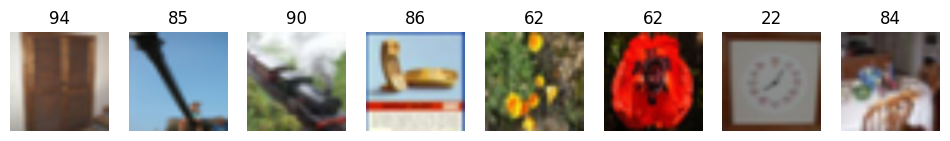

In [11]:
# Function to show a batch of images
def show_batch(dl, n=8):
    imgs, labels = next(iter(dl))
    imgs = imgs[:n]
    labels = labels[:n]

    plt.figure(figsize=(12, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        img = imgs[i].permute(1, 2, 0).cpu().numpy() * np.array(CIFAR100_STD) + np.array(CIFAR100_MEAN)
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(int(labels[i]))
        plt.axis("off")
    plt.show()

# Show a batch of training images
show_batch(train_loader, n=8)

### AlexNet (Model Architecture)
- ปรับให้รองรับ CIFAR-100 (100 classes) ซึ่งมีภาพขนาด 32×32 (แต่เราขยายเป็น 224×224 แล้วก่อนหน้านี้)
- AlexNet ประกอบด้วย 8 เลเยอร์หลักที่มีพารามิเตอร์ 5 เลเยอร์แรกเป็น Convolutional Layers และ 3 เลเยอร์สุดท้ายเป็น Fully Connected Layers
- ใช้ ReLU เป็น activation function, LRN (Local Response Normalization) สำหรับ normalization,
และ Dropout เพื่อลด overfitting

In [13]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=100, use_lrn=True):
        super().__init__()

        # Feature Extractor
        self.features = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0) if use_lrn else nn.Identity(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Convolutional Layer 2
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0) if use_lrn else nn.Identity(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Convolutional Layer 3
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Convolutional Layer 4
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Convolutional Layer 5
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # Adaptive Average Pooling to get fixed size output
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        # Initialize weights as per the original paper: Gaussian(0, 0.01)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                nn.init.constant_(m.bias, 0.0)

    # Define the forward pass
    def forward(self, x):
        x = self.features(x) # Feature extraction
        x = self.avgpool(x) # Adaptive average pooling
        x = torch.flatten(x, 1) # flatten the tensor
        x = self.classifier(x) # Classification
        return x

In [26]:
USE_LRN = not torch.backends.mps.is_available() # LRN is not supported on MPS

# Create the model and move it to the device (MPS / CUDA / CPU)
model = AlexNet(num_classes=100, use_lrn=USE_LRN).to(DEVICE)

# Show total number of parameters in the model
sum(p.numel() for p in model.parameters()), model

(58691044,
 AlexNet(
   (features): Sequential(
     (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
     (1): ReLU(inplace=True)
     (2): Identity()
     (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
     (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
     (5): ReLU(inplace=True)
     (6): Identity()
     (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
     (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): ReLU(inplace=True)
     (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU(inplace=True)
     (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (13): ReLU(inplace=True)
     (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
   (classifier): Sequential(
     (0): Dropout(p=0.5, inplac

### Loss, Optimizer, Metrics

In [27]:
# Hyperparameters
LR = 1e-3 # learning rate
EPOCHS = 30 # number of training epochs
WEIGHT_DECAY = 5e-4  # L2 regularization
    
# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for 100-class classification
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=LR, 
    weight_decay=WEIGHT_DECAY
)

# Metrics
num_classes = 100
acc_metric_val = MulticlassAccuracy(num_classes=num_classes).to(DEVICE)
acc_metric_test = MulticlassAccuracy(num_classes=num_classes).to(DEVICE)

### Train / Validate Loop (with early stopping)

In [28]:
# Training function for one epoch

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        # Forward pass
        logits = model(x)
        loss = criterion(logits, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return running_loss / total, correct / total

In [29]:
# Evaluation function

def evaluate(model, loader, criterion, metric):
    model.eval()
    metric.reset()
    running_loss, total = 0.0, 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = criterion(logits, y)
            running_loss += loss.item() * x.size(0)
            total += y.size(0)
            metric.update(logits, y)
    return running_loss/total, metric.compute().item()

In [30]:
# Training / Validation loop with early stopping

best_val_acc, best_state = 0.0, None
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()

    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion, acc_metric_val)

    # Record history
    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # Save best model (early stopping)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    elapsed = time.time() - start_time
    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.4f} | "
          f"time {elapsed:.1f}s")

Epoch 01 | train loss 4.3110 acc 0.0335 | val loss 4.0659 acc 0.0582 | time 206.3s
Epoch 02 | train loss 3.9361 acc 0.0778 | val loss 3.7514 acc 0.1029 | time 1148.2s
Epoch 03 | train loss 3.7465 acc 0.1118 | val loss 3.5792 acc 0.1374 | time 186.2s
Epoch 04 | train loss 3.5600 acc 0.1445 | val loss 3.3733 acc 0.1796 | time 190.7s
Epoch 05 | train loss 3.4246 acc 0.1717 | val loss 3.2466 acc 0.2047 | time 193.7s
Epoch 06 | train loss 3.3184 acc 0.1893 | val loss 3.1689 acc 0.2238 | time 191.5s
Epoch 07 | train loss 3.2297 acc 0.2080 | val loss 3.0796 acc 0.2338 | time 188.5s
Epoch 08 | train loss 3.1629 acc 0.2221 | val loss 2.9760 acc 0.2568 | time 185.1s
Epoch 09 | train loss 3.1109 acc 0.2319 | val loss 2.9212 acc 0.2744 | time 183.3s
Epoch 10 | train loss 3.0467 acc 0.2436 | val loss 2.8375 acc 0.2916 | time 186.1s
Epoch 11 | train loss 2.9918 acc 0.2529 | val loss 2.8579 acc 0.2888 | time 183.9s
Epoch 12 | train loss 2.9647 acc 0.2582 | val loss 2.8151 acc 0.3001 | time 183.7s
Epo

In [45]:
# Load the best model state (early stopping)
if best_state is not None:
    model.load_state_dict(best_state)
    model.to(DEVICE)

### Plot Accuracy & Loss per Epoch

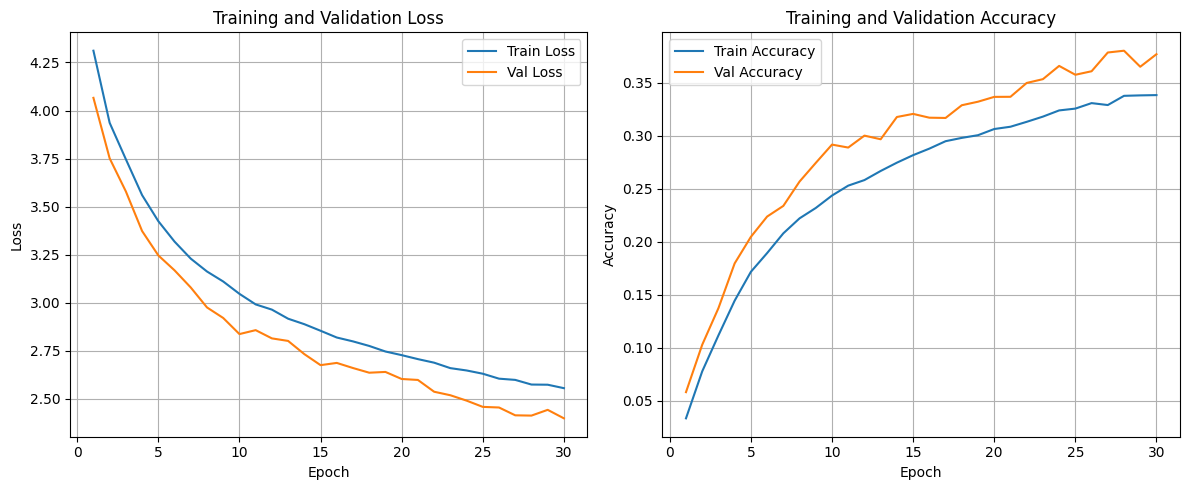

In [31]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Plot Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train Accuracy")
plt.plot(epochs, history["val_acc"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

- Loss ยังลดต่อเนื่อง และ Accuracy ยังเพิ่มขึ้นเรื่อย ๆ ไม่ plateau แปลว่าโมเดลยัง ไม่ถึงจุดอิ่มตัวของการเรียนรู้ (undertrained)
- เพิ่มจำนวนรอบ (epochs) จาก 30 → 120–150 รอบ
เพื่อให้โมเดลมีเวลาเรียนรู้ pattern ใน CIFAR-100 มากขึ้น
โดยเฉพาะอย่างยิ่ง AlexNet มีพารามิเตอร์จำนวนมาก (~60 ล้านตัว)
จึงต้องการการฝึกที่ยาวกว่าโมเดลขนาดเล็กอย่าง LeNet-5

### Test & Evaluate (accuracy, confusion matrix, per-class report)

In [33]:
# Evaluate on test set
test_loss, test_acc = evaluate(model, test_loader, criterion, acc_metric_test)
print(f"TEST | loss {test_loss:.4f} | acc {test_acc:.4f}")

TEST | loss 2.4150 | acc 0.3847


In [34]:
# Confusion Matrix
cm_metric = MulticlassConfusionMatrix(num_classes=num_classes).to(DEVICE)
model.eval()
cm_metric.reset()

# Compute confusion matrix
with torch.no_grad():
    for x,y in test_loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        cm_metric.update(logits, y)
cm = cm_metric.compute().cpu().numpy()

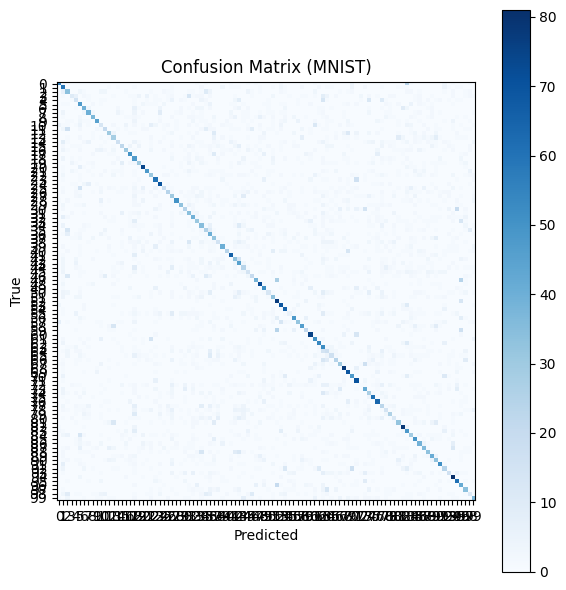

In [35]:
# Plot confusion matrix
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix (MNIST)')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, tick_marks); plt.yticks(tick_marks, tick_marks)
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.show()

In [43]:
# Save the model checkpoint
Path("checkpoints").mkdir(exist_ok=True)
torch.save(model.state_dict(), "checkpoints/alexnet_cifar100.pt")

In [44]:
# Load the model checkpoint
m2 = AlexNet().to(DEVICE)
m2.load_state_dict(torch.load("checkpoints/alexnet_cifar100.pt", map_location=DEVICE))
m2.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2.0)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2.0)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (cla